In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
import os
os.chdir('E:\\VCU Bridge course')

# Function to install and load libraries
def install_and_load(package):
    import importlib
    try:
        importlib.import_module(package)
    except ImportError:
        import subprocess
        subprocess.check_call(["python", '-m', 'pip', 'install', package])
    finally:
        globals()[package] = importlib.import_module(package)

# Load required libraries
libraries = ["pandas", "geopandas", "matplotlib", "seaborn"]
for lib in libraries:
    install_and_load(lib)

In [2]:
# Reading the file into pandas
data = pd.read_csv("NSSO68.csv", dtype={'grp': str})

# Filtering for UP
df = data[data['state_1'] == "UP"]

# Display dataset info
print("Dataset Information:")
print(df.columns)

# Finding missing values
missing_info = df.isna().sum()
print("Missing Values Information:")
print(missing_info)

Dataset Information:
Index(['slno', 'grp', 'Round_Centre', 'FSU_number', 'Round', 'Schedule_Number',
       'Sample', 'Sector', 'state', 'State_Region',
       ...
       'pickle_v', 'sauce_jam_v', 'Othrprocessed_v', 'Beveragestotal_v',
       'foodtotal_v', 'foodtotal_q', 'state_1', 'Region', 'fruits_df_tt_v',
       'fv_tot'],
      dtype='object', length=384)
Missing Values Information:
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


In [3]:
# Subsetting the data
upnew = df[['state_1', 'District', 'Region', 'Sector', 'State_Region', 'Meals_At_Home', 'ricepds_v', 'Wheatpds_q', 'chicken_q', 'pulsep_q', 'wheatos_q', 'No_of_Meals_per_day']]

# Impute missing values with mean for specific columns
upnew.loc[:, 'Meals_At_Home'] = upnew['Meals_At_Home'].fillna(upnew['Meals_At_Home'].mean())

# Finding outliers and removing them
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]

for col in ['ricepds_v', 'chicken_q']:
    upnew = remove_outliers(upnew, col)

In [4]:
# Summarize consumption
upnew['total_consumption'] = upnew[['ricepds_v', 'Wheatpds_q', 'chicken_q', 'pulsep_q', 'wheatos_q']].sum(axis=1)

# Convert infinite values to NaN
upnew.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Summarize and display top consuming districts and regions
district_summary = upnew.groupby('District')['total_consumption'].sum().reset_index().sort_values(by='total_consumption', ascending=False)
region_summary = upnew.groupby('Region')['total_consumption'].sum().reset_index().sort_values(by='total_consumption', ascending=False)

print("Top Consuming Districts:")
print(district_summary.head(4))

print("Region Consumption Summary:")
print(region_summary)


Top Consuming Districts:
    District  total_consumption
14        15        1323.015188
10        11        1228.852129
11        12        1124.361810
1          2        1061.463651
Region Consumption Summary:
   Region  total_consumption
4       5       13449.489887
2       3       12949.177897
0       1        7396.093142
1       2        6494.791811
3       4        3667.097532


In [8]:
# Rename districts and sectors
district_mapping_up = {
    "1": "Saharanpur", "2": "Muzaffarnagar", "3": "Bijnor", "4": "Moradabad", "5": "Rampur",
    "6": "Jyotiba Phule Nagar", "7": "Meerut", "8": "Baghpat", "9": "Ghaziabad", "10": "Gautam Buddha Nagar",
    "11": "Bulandshahar", "12": "Aligarh", "13": "Hathras", "14": "Mathura", "15": "Agra",
    "16": "Firozabad", "17": "Etah", "18": "Mainpuri", "19": "Budaun", "20": "Bareilly",
    "21": "Pilibhit", "22": "Shahjahanpur", "23": "Kheri", "24": "Sitapur", "25": "Hardoi",
    "26": "Unnao", "27": "Lucknow", "28": "Rae Bareli", "29": "Farrukhabad", "30": "Kannauj",
    "31": "Etawah", "32": "Auraiya", "33": "Kanpur Dehat", "34": "Kanpur Nagar", "35": "Jalaun",
    "36": "Jhansi", "37": "Lalitpur", "38": "Hamirpur", "39": "Mahoba", "40": "Banda",
    "41": "Chitrakoot", "42": "Fatehpur", "43": "Pratapgarh", "44": "Kaushambi", "45": "Allahabad",
    "46": "Barabanki", "47": "Faizabad", "48": "Ambedkar Nagar", "49": "Sultanpur", "50": "Bahraich",
    "51": "Shrawasti", "52": "Balrampur", "53": "Gonda", "54": "Siddharthnagar", "55": "Basti",
    "56": "Sant Kabir Nagar", "57": "Mahrajganj", "58": "Gorakhpur", "59": "Kushinagar", "60": "Deoria",
    "61": "Azamgarh", "62": "Mau", "63": "Ballia", "64": "Jaunpur", "65": "Ghazipur",
    "66": "Chandauli", "67": "Varanasi", "68": "Sant Ravidas Nagar Bhadohi", "69": "Mirzapur", "70": "Sonbhadra",
    "71": "Kashiramnagar"
}

sector_mapping = {"2": "URBAN", "1": "RURAL"}

upnew['District'] = upnew['District'].astype(str).map(district_mapping_up)
upnew['Sector'] = upnew['Sector'].astype(str).map(sector_mapping)

C:\Users\manor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


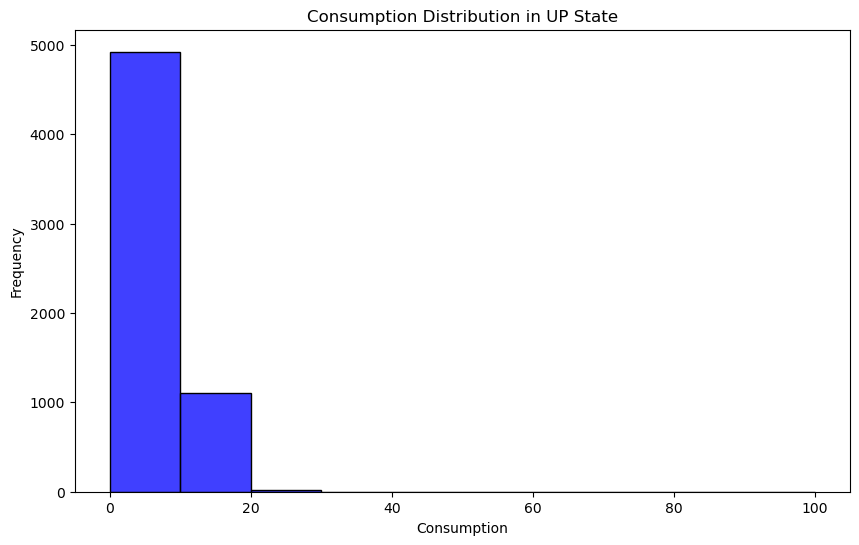

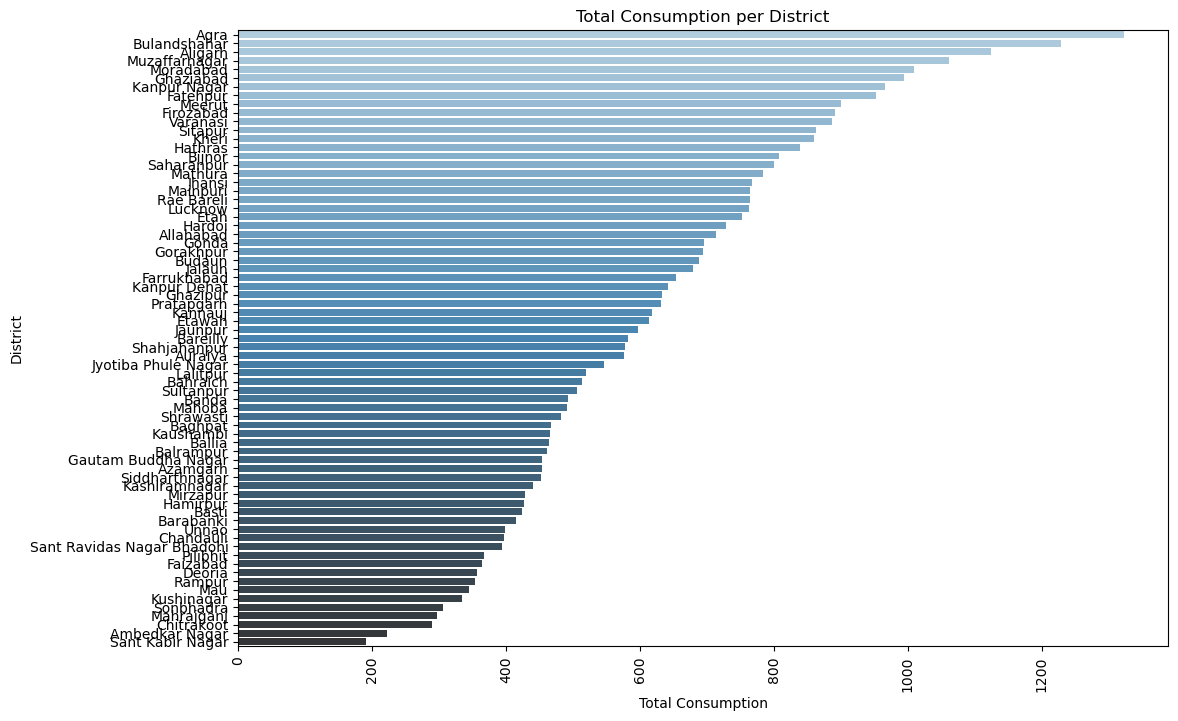

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(upnew['total_consumption'], bins=10, color='blue', kde=False)
plt.xlabel("Consumption")
plt.ylabel("Frequency")
plt.title("Consumption Distribution in UP State")
plt.show()

UP_consumption = upnew.groupby('District')['total_consumption'].sum().reset_index()
UP_consumption = UP_consumption.sort_values(by='total_consumption', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='total_consumption', y='District', data=UP_consumption, palette='Blues_d')
plt.xlabel("Total Consumption")
plt.ylabel("District")
plt.title("Total Consumption per District")
plt.xticks(rotation=90)
plt.show()

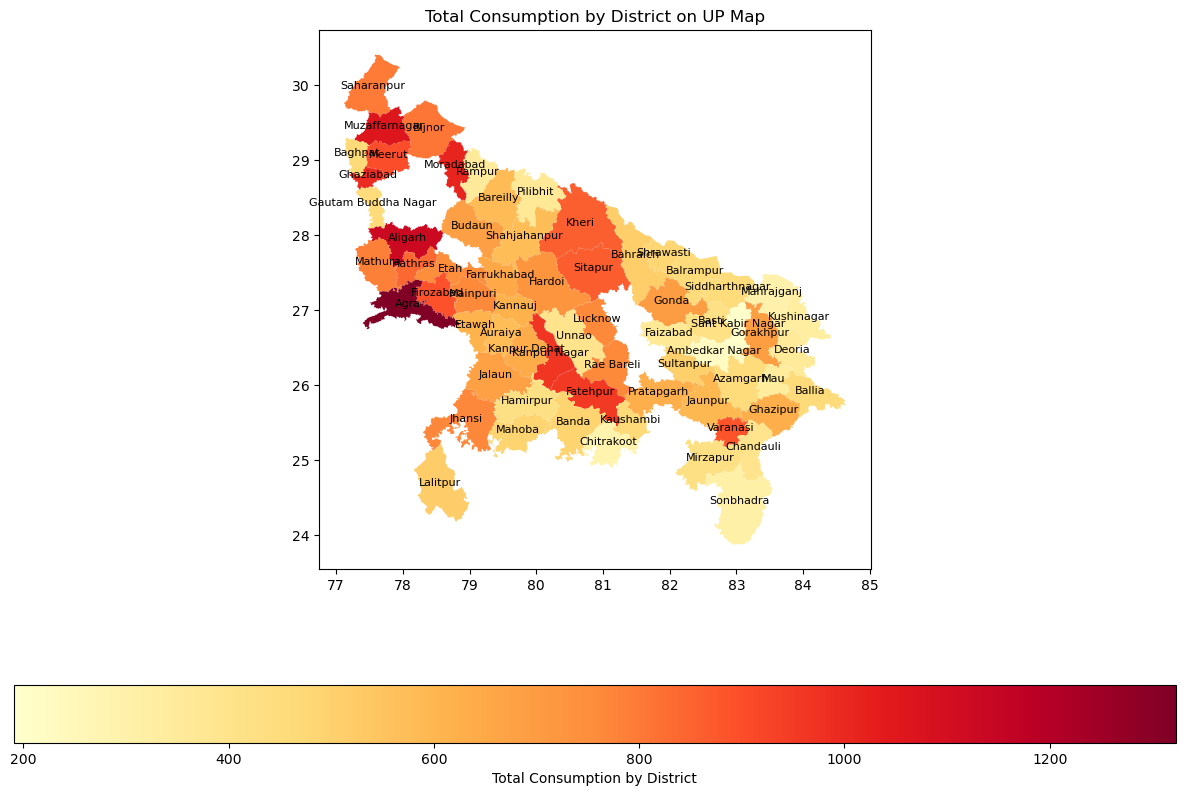

In [11]:
# Plot on UP state map
data_map = gpd.read_file("E:\\VCU Bridge course\\UTTAR PRADESH_DISTRICTS.geojson")

data_map = data_map.rename(columns={'dtname': 'District'})

data_map_data = data_map.merge(UP_consumption, on='District')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
data_map_data.plot(column='total_consumption', ax=ax, legend=True, cmap='YlOrRd', legend_kwds={'label': "Total Consumption by District", 'orientation': "horizontal"})
data_map_data.apply(lambda x: ax.annotate(text=x.District, xy=x.geometry.centroid.coords[0], ha='center', fontsize=8, color='black'), axis=1)
plt.title("Total Consumption by District on UP Map")
plt.show()